In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import torch
import imutils
# monkey patches visualization and provides helpers to load geometries
sys.path.append('Open3D-master/examples/python/')
import open3d.data  as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def init_model():
    '''
    Initializes the MiDaS model and transforms.

    Returns:
    - midas: The MiDaS model.
    - transform: The MiDaS model transforms.
    - device: The device (CPU or GPU) on which the model is loaded.
    '''
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform
    return midas, transform, device

def GetPointCloud(image):
    '''
    GetPointCloud function takes an image as input and returns the corresponding point cloud.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    numpy.ndarray: The point cloud generated from the input image.
    '''
    midas, transform, device = init_model()
    input_batch = transform(image).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    torch.cuda.empty_cache()
    output = output / np.max(output)
    return output

In [3]:
filename = 'Images\photo_2023-12-13_02-50-18.jpg'
img1 = cv2.imread(filename)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = imutils.resize(img1, height= 480)

filename = 'Images\photo_2023-12-13_02-50-21.jpg'
img2 = cv2.imread(filename)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = imutils.resize(img2, height= 480)

In [6]:
depth1 = GetPointCloud(img1)
depth2 = GetPointCloud(img2)

Using cache found in C:\Users\LENOVO/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\LENOVO/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\LENOVO/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\LENOVO/.cache\torch\hub\intel-isl_MiDaS_master


(-0.5, 479.5, 479.5, -0.5)

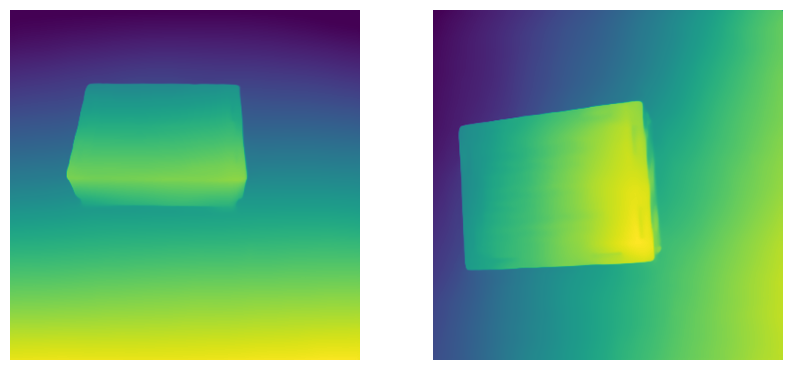

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(depth1)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(depth2)
plt.axis('off')

In [ ]:
# cv2.imwrite(f'Images/measured_images/Depth_maps/{image_name}.png',o * 255)

True

In [8]:
image1 = o3d.geometry.Image(img1)
depth1 = o3d.geometry.Image(depth1)

image2 = o3d.geometry.Image(img2)
depth2 = o3d.geometry.Image(depth2)

In [9]:
rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image1, depth1)

rgbd_image2 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image2, depth2)

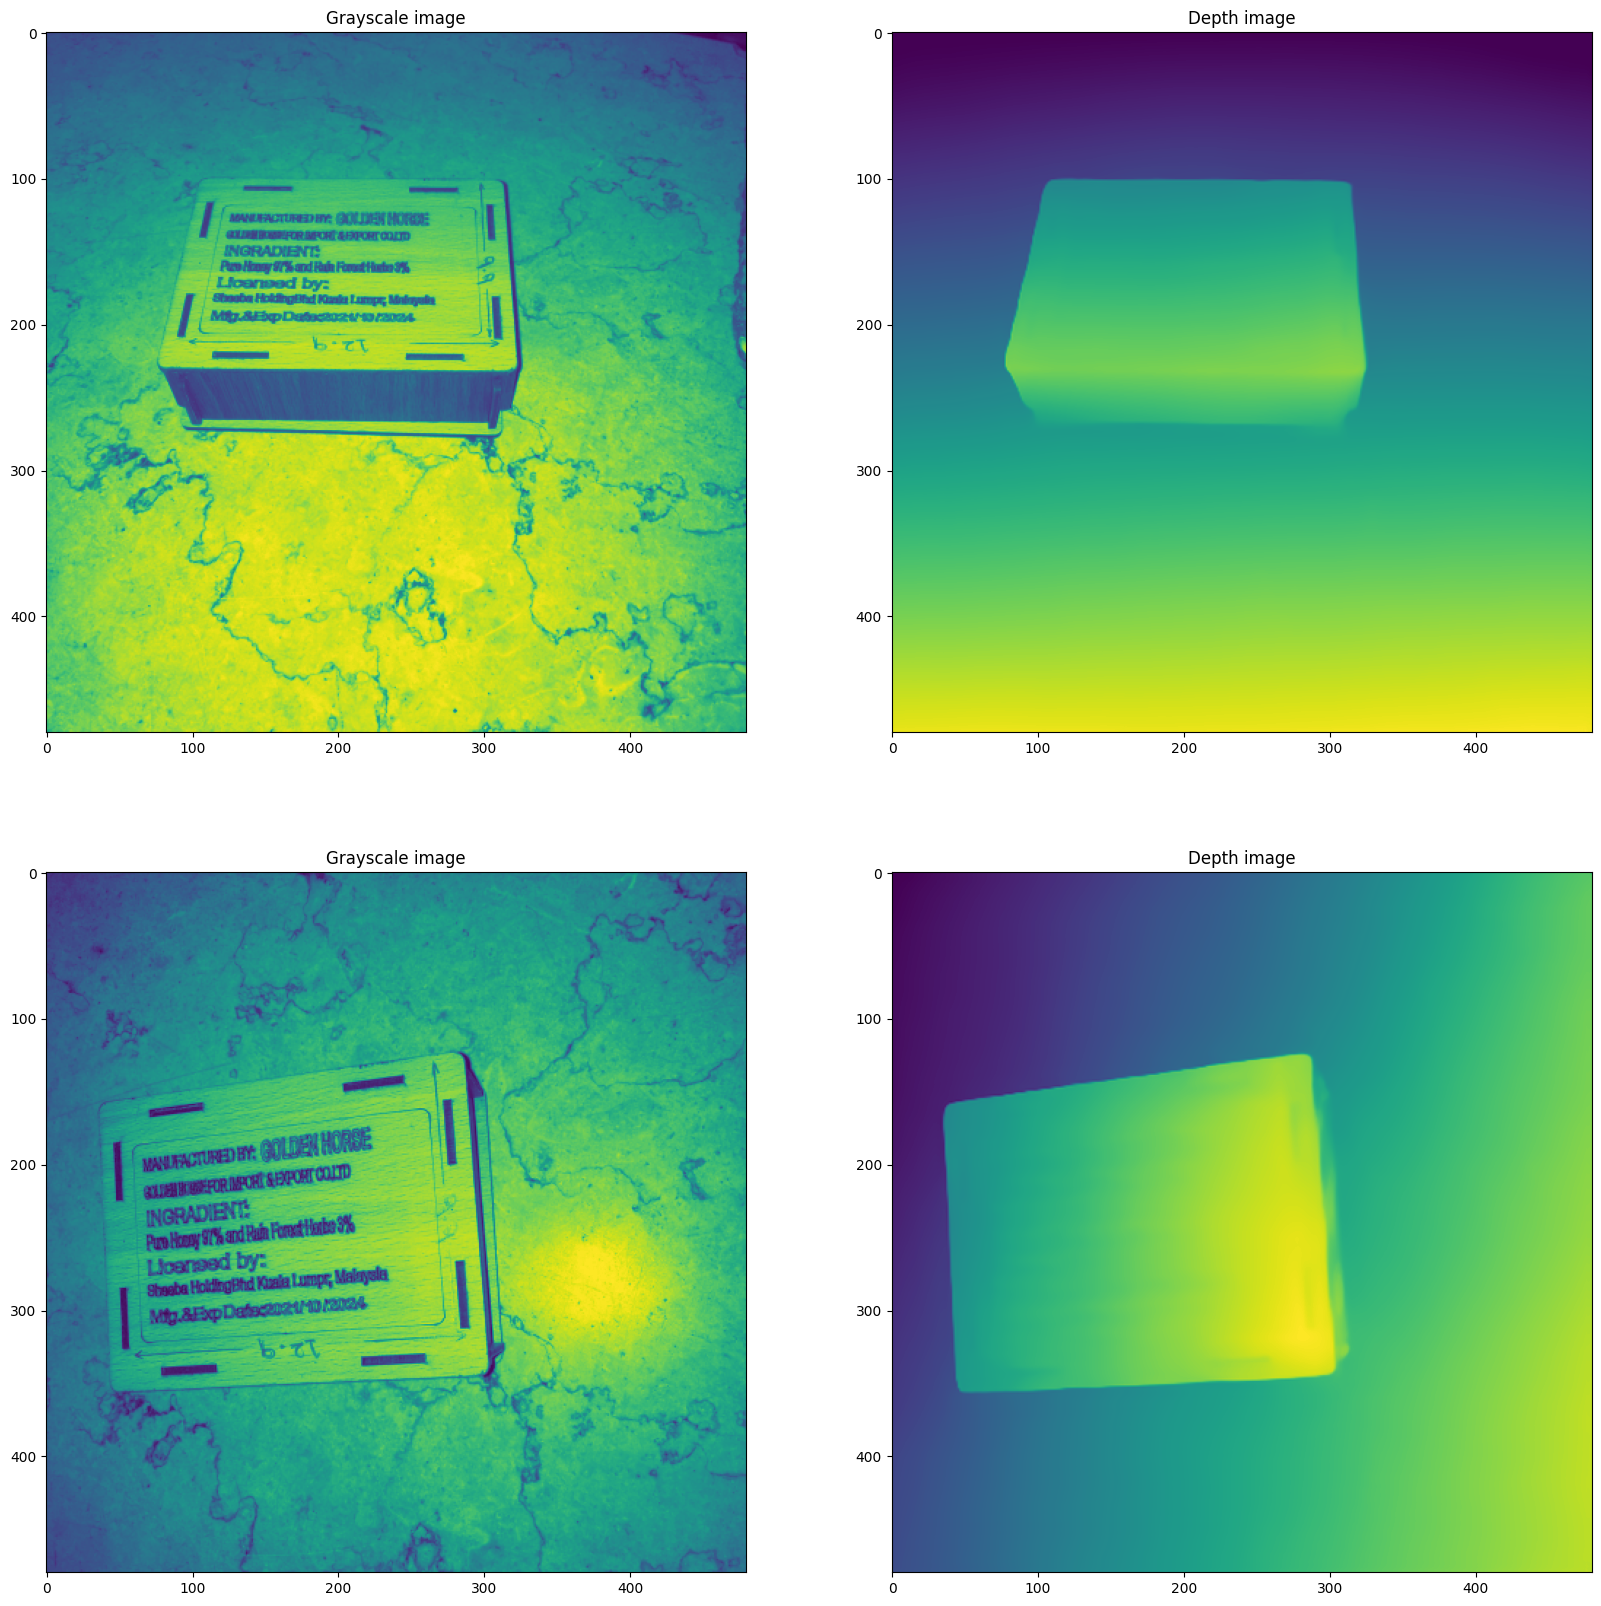

In [10]:
# Plot the images
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.title('Grayscale image')
plt.imshow(rgbd_image1.color)
plt.subplot(2, 2, 2)
plt.title('Depth image')
plt.imshow(rgbd_image1.depth)

# Plot the images
plt.subplot(2, 2, 3)
plt.title('Grayscale image')
plt.imshow(rgbd_image2.color)
plt.subplot(2, 2, 4)
plt.title('Depth image')
plt.imshow(rgbd_image2.depth)

plt.show()

In [11]:
# Camera intrinsic parameters built into Open3D for Prime Sense
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

In [12]:
# # Create the point cloud from images and camera intrisic parameters
pcd1 = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image1, camera_intrinsic)
    
# # Flip it, otherwise the pointcloud will be upside down
pcd1.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
              )
o3d.visualization.draw_geometries([pcd1])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [13]:
# # Create the point cloud from images and camera intrisic parameters
pcd2 = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image2, camera_intrinsic)
    
# # Flip it, otherwise the pointcloud will be upside down
pcd2.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
              )
o3d.visualization.draw_geometries([pcd2])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
